<a href="https://colab.research.google.com/github/Isafon/ECE528/blob/main/ECE528_ASN5_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout,BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kddcup.data.gz to kddcup.data.gz


#### load the KDDCup99 dataset and specify column names for readability

In [ ]:
# Load dataset
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
           "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
           "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
           "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
           "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
           "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
           "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("kddcup.data.gz", sep=",", names=columns, index_col=None)

#### convert the 'label' column to binary (0 for normal, 1 for anomaly).

In [ ]:

df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# Filter for HTTP traffic
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)

#### label encode any categorical features in the dataset to convert them into numerical format.

In [ ]:
# Encode categorical features
for col in df.columns:
    if df[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(df[col])
        df[col] = encoded.transform(df[col])

#### Here, we separate the normal and anomalous data for use in semi-supervised learning.

In [ ]:
# Split into normal (0) and anomalous (1)
df_normal = df[df['label'] == 0]  # Normal traffic
df_anomalous = df[df['label'] == 1]  # Anomalies

#### We take only the normal data (X_normal) for training and testing.
#### We perform an 80-20 split on the normal data for training and validation.

In [ ]:
# Split normal data into training and test sets
X_normal = df_normal.drop(columns=['label'])
y_normal = df_normal['label']

X_train, X_test = train_test_split(X_normal, test_size=0.2, random_state=42)

#### We remove extreme outliers by clipping values beyond the 99th percentile and apply Min-Max scaling to normalize the features.

In [ ]:

# Clip outliers and apply Min-Max scaling
clip_value = np.percentile(X_train, 99)
X_train_clipped = np.clip(X_train, 0, clip_value)
X_test_clipped = np.clip(X_test, 0, clip_value)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_clipped)
X_test_scaled = scaler.transform(X_test_clipped)

#### Building the Autoencoder Model

In [ ]:
from tensorflow.keras import layers, models, regularizers, optimizers

input_dim = X_train_scaled.shape[1]

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu',
                       activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = layers.Dense(32, activation='relu')(encoded)
bottleneck = layers.Dense(16, activation='relu')(encoded)   # latent layer

# Decoder
decoded = layers.Dense(32, activation='relu')(bottleneck)
decoded = layers.Dense(64, activation='relu')(decoded)
output_layer = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Model definition
autoencoder = models.Model(inputs=input_layer, outputs=output_layer)

# Compile model
autoencoder.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='mse'
)

autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,488 (40.97 KB)

 Trainable params: 10,488 (40.97 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the autoencoder, replace the 'autoencoder' with the model name you set above
# You can update hyperparameters and add regularization techniques as needed

history = autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32,
                          validation_split=0.2, verbose=1)

Epoch 1/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0069 - val_loss: 3.1036e-04
Epoch 2/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 3.0241e-04 - val_loss: 2.3956e-04
Epoch 3/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 2.3763e-04 - val_loss: 2.1274e-04
Epoch 4/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 2.1151e-04 - val_loss: 1.8131e-04
Epoch 5/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 1.8885e-04 - val_loss: 1.6984e-04
Epoch 6/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 1.7278e-04 - val_loss: 1.5514e-04
Epoch 7/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 1.5849e-04 - val_loss: 1.7547e-04
Epoch 8/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 1.4256e-04 - val_loss: 1.4529e-04
Epoch 9/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 1.4083e-04 - val_loss: 1.2978e-04
Epoch 10/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 1.3910e-04 - val_loss: 1.7281e-04
Epoch 11/50
1

#### We calculate the reconstruction error for normal test data. Aslo adjust the default threshold to your desired percentile of the normal data's reconstruction error to see what effect it will have.

In [ ]:
# Calculate reconstruction error on test data

reconstructed_data = autoencoder.predict(X_test_scaled)
mse_normal = np.mean(np.power(X_test_scaled - reconstructed_data, 2), axis=1)

# Set threshold for anomaly detection
threshold = np.percentile(mse_normal, 92) #you can adjust this percentile value

3870/3870 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


#### We apply the autoencoder to the anomalous data and compute its reconstruction error, and combine the reconstruction errors from normal and anomalous data.

In [ ]:
# Test the autoencoder on anomalous data
X_anomalous = df_anomalous.drop(columns=['label'])
X_anomalous_scaled = scaler.transform(X_anomalous)
reconstructed_anomalous = autoencoder.predict(X_anomalous_scaled)
mse_anomalous = np.mean(np.power(X_anomalous_scaled - reconstructed_anomalous, 2), axis=1)

# Combine normal and anomalous MSEs
combined_mse = np.concatenate([mse_normal, mse_anomalous])
combined_labels = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_anomalous))])


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


#### We classify the data as normal or anomalous based on the threshold and  calculate precision, recall, and F1-score to evaluate the model.

In [ ]:

# Evaluate the model
y_pred = [1 if e > threshold else 0 for e in combined_mse]

precision = precision_score(combined_labels, y_pred)
recall = recall_score(combined_labels, y_pred)
f1 = f1_score(combined_labels, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.2899641577060932
Recall: 1.0
F1-score: 0.4495693248124479


#### plot the training and validation loss to observe how the model performed over the epochs.

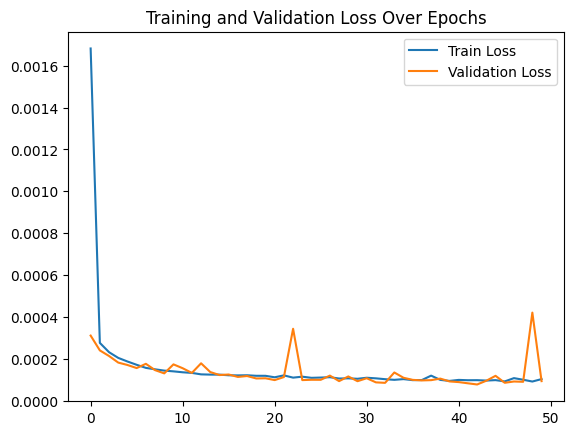

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss Over Epochs")
plt.show()

#### Visualize the distribution of reconstruction errors and the anomaly detection threshold.

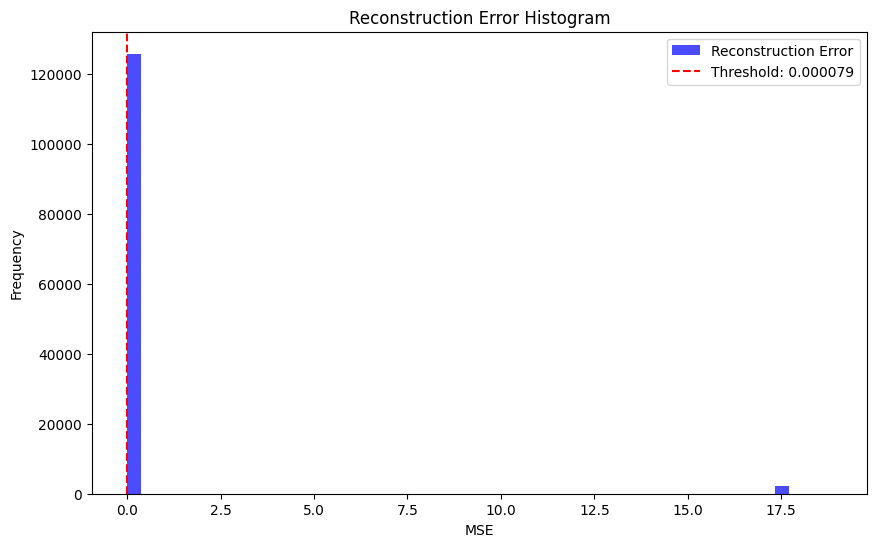

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(combined_mse, bins=50, color='blue', alpha=0.7, label='Reconstruction Error')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.title("Reconstruction Error Histogram")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### plot the reconstruction error for anomalous data only, showing how well the autoencoder reconstructs normal samples.

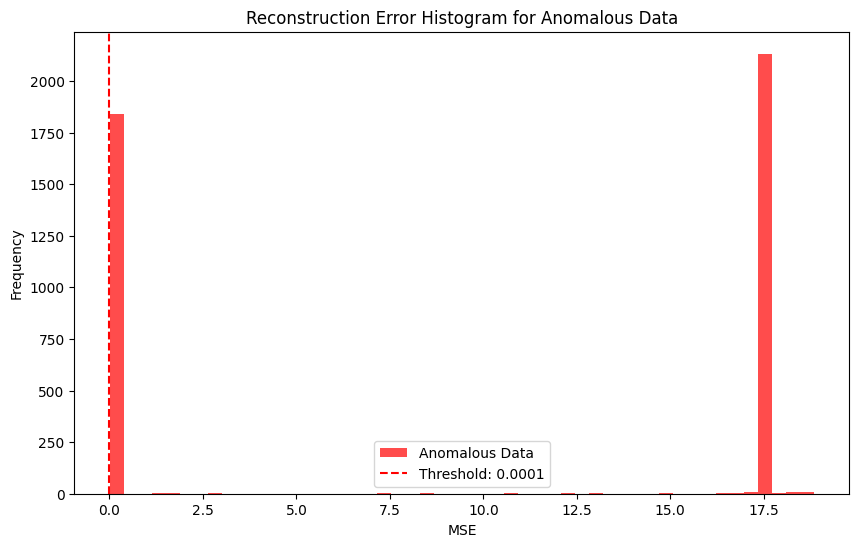

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(mse_anomalous, bins=50, color='red', alpha=0.7, label='Anomalous Data')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title("Reconstruction Error Histogram for Anomalous Data")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.show()